# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 16th of december at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 8 décembre 2021**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Zakaria"
ln1 = "ECHCHAIR"
fn2 = "Marouane"
ln2 = "NAJID"

filename = (
    "_".join(map(lambda s: s.strip().lower(), ["lab1", ln1, fn1, "and", ln2, fn2]))
    + ".ipynb"
)
print(filename)

lab1_echchair_zakaria_and_najid_marouane.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

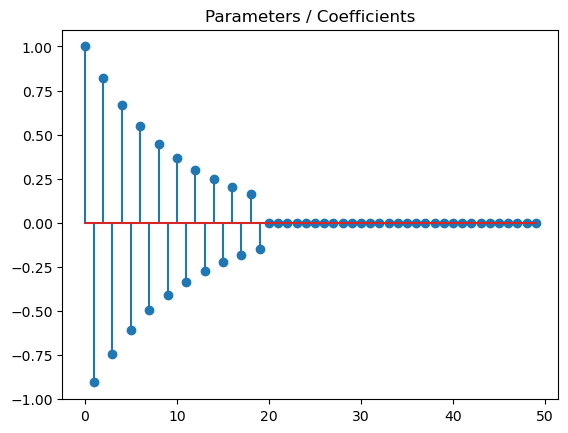

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.0)
coefs[20:] = 0.0
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1.0 / (1.0 + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

<ipython-input-5-04d3d3eecab5>:2: DeprecationWarning: Please use `toeplitz` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import toeplitz


## Generate the data

In [6]:
A, b = simu_linreg(coefs)
# A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

In [7]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    return np.sign(x) * np.maximum(np.abs(x) - lmbd, 0)


def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.sum(np.abs(x))


def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    return x / (1 + lmbd)


def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd * 0.5 * np.sum(x**2)

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2.0, 2.0)

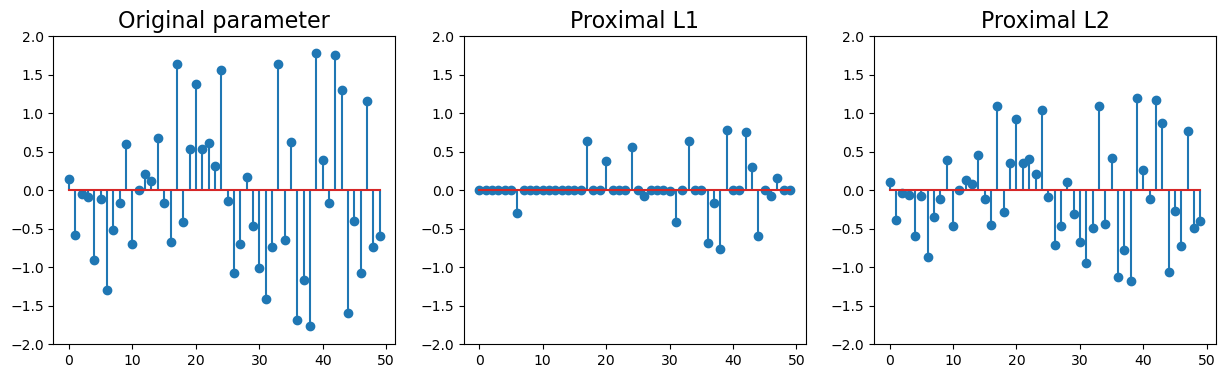

In [8]:
x = np.random.randn(50)
l_l1 = 1.0
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

<div class="alert alert-warning">

- When using L1 proximal operator, we just shrinked the small values of the coefficients to zeros and the other values are just reduced by $-s$ in absolute value. Therefore, we induced sparsity into the problem structure.

- When using L2 proximal operator, all we did was dividing our vector's coefficients by $1+s$ which means we reduced their values by the factor $\frac{1}{1+s}$ without setting any to zero.
</div>

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [9]:
def loss_linreg(x):
    """Least-squares loss"""
    return (A @ x - b).T @ (A @ x - b) / (2 * n_samples)


def grad_linreg(x):
    """Leas-squares gradient"""
    return A.T @ (A @ x - b) / n_samples


def loss_logreg(x):
    """Logistic loss"""
    return np.sum(np.log(1 + np.exp(-(A @ x).flatten() * b))) / b.shape[0]


def grad_logreg(x):
    """Logistic gradient"""
    return np.average(
        -b * A.T * np.exp(-(A @ x).flatten() * b) / (1 + np.exp(-(A @ x).flatten() * b)),
        axis=1,
    )

In [10]:
x = np.random.rand(50)

In [11]:
from scipy.optimize import check_grad

print("Check the linreg gradient: ", check_grad(loss_logreg, grad_logreg, x))
print("Check the logreg gradient: ", check_grad(loss_linreg, grad_linreg, x))

Check the linreg gradient:  2.2269937954937096e-07
Check the logreg gradient:  1.7887814336422428e-06


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [12]:
from numpy.linalg import norm

In [13]:
# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""
    return norm(A, ord=2) ** 2 / n_samples


# Calculate the smoothness constant for Logistic loss + L2 regularizor
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""
    return norm(A, ord=2) ** 2 / (n_samples * 4)


def PGD(
    x0, f, grad_f, R, prox_R, step, lmbd=0.0, n_iter=50, x_true=coefs, verbose=True
):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(" | ".join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_R(x - grad_f(x) / step, lmbd / step)

        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(
                " | ".join(
                    [
                        ("%d" % k).rjust(8),
                        ("%.2e" % obj).rjust(8),
                        ("%.2e" % err).rjust(8),
                    ]
                )
            )
    return x, objectives, errors

In [14]:
def APGD(
    x0, f, grad_f, R, prox_R, step, lmbd=0.0, n_iter=50, x_true=coefs, verbose=True
):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.0
    t_new = 1.0
    if verbose:
        print("Lauching APGD solver...")
        print(" | ".join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new = prox_R(z - grad_f(z) / step, lmbd / step)
        t_new = (1 + np.sqrt(1 + 4 * (t**2))) / 2
        z = x_new + (t - 1) * (x_new - x) / t_new

        x = x_new
        t = t_new

        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(
                " | ".join(
                    [
                        ("%d" % k).rjust(8),
                        ("%.2e" % obj).rjust(8),
                        ("%.2e" % err).rjust(8),
                    ]
                )
            )
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [15]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters give above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [16]:
x_TRUE, obj, err = APGD(
    x0,
    loss_linreg,
    grad_linreg,
    L2_norm,
    prox_L2,
    step=smoothness_const_linreg(A),
    lmbd=lmbd,
    x_true=coefs,
    n_iter=1000,
    verbose=False,
)
print("Real X: \n", x_TRUE)

Real X: 
 [ 9.49e-01 -7.95e-01  7.33e-01 -7.05e-01  5.38e-01 -5.37e-01  5.09e-01
 -4.65e-01  4.32e-01 -4.64e-01  3.27e-01 -1.60e-01  2.43e-01 -2.46e-01
  2.10e-01 -2.20e-01  1.56e-01 -1.25e-01  1.12e-01 -1.19e-01 -5.20e-02
  3.40e-02 -6.68e-03  1.92e-02 -2.19e-03 -4.49e-02  1.45e-02  1.79e-02
  5.38e-03 -6.25e-02 -7.15e-03  1.56e-03  5.19e-02  4.64e-03 -4.00e-02
 -2.30e-02  3.41e-02 -7.57e-02 -4.48e-02  2.84e-02  4.24e-03 -2.84e-02
  4.25e-02  1.12e-02  2.71e-03 -5.05e-02  5.78e-02 -3.97e-02  7.87e-04
  2.03e-02]


In [17]:
x_PGD, obj_PGD, err_PGD = PGD(
    x0,
    loss_linreg,
    grad_linreg,
    L2_norm,
    prox_L2,
    step=smoothness_const_linreg(A),
    lmbd=lmbd,
    x_true=x_TRUE,
    n_iter=100,
    verbose=True,
)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 1.16e+00 | 8.80e-01
      10 | 5.79e-01 | 2.93e-01
      20 | 5.23e-01 | 1.04e-01
      30 | 5.16e-01 | 3.74e-02
      40 | 5.15e-01 | 1.36e-02
      50 | 5.15e-01 | 4.98e-03
      60 | 5.15e-01 | 1.83e-03
      70 | 5.15e-01 | 6.78e-04
      80 | 5.15e-01 | 2.52e-04
      90 | 5.15e-01 | 9.39e-05
     100 | 5.15e-01 | 3.52e-05


In [18]:
x_APGD, obj_APGD, err_APGD = APGD(
    x0,
    loss_linreg,
    grad_linreg,
    L2_norm,
    prox_L2,
    step=smoothness_const_linreg(A),
    lmbd=lmbd,
    x_true=x_TRUE,
    n_iter=100,
    verbose=True,
)

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.16e+00 | 8.80e-01
      10 | 5.16e-01 | 2.42e-02
      20 | 5.15e-01 | 7.47e-03
      30 | 5.15e-01 | 2.71e-03
      40 | 5.15e-01 | 1.14e-03
      50 | 5.15e-01 | 5.53e-04
      60 | 5.15e-01 | 2.91e-04
      70 | 5.15e-01 | 1.58e-04
      80 | 5.15e-01 | 8.63e-05
      90 | 5.15e-01 | 4.75e-05
     100 | 5.15e-01 | 2.62e-05


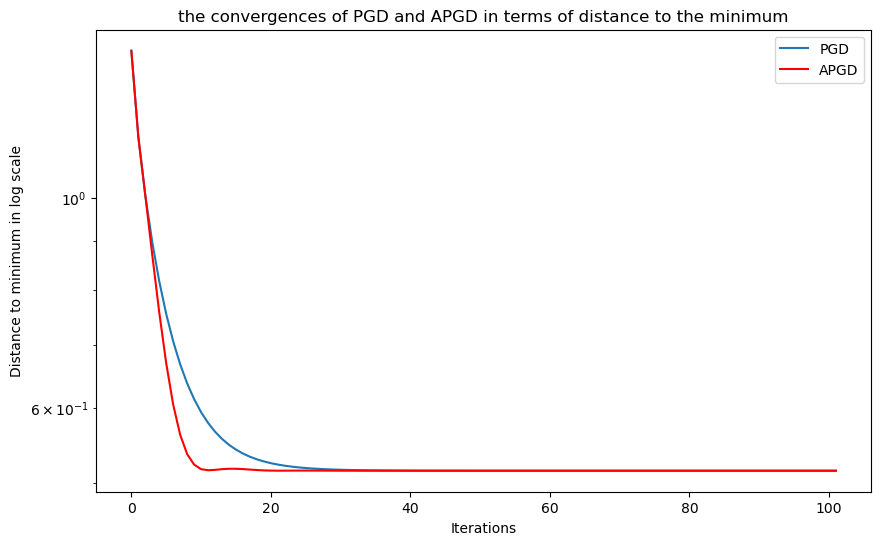

In [19]:
# Distance  to the minimum
plt.figure(figsize=(10, 6))
plt.plot(obj_PGD, label="PGD")
plt.plot(obj_APGD, "r", label="APGD")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Distance to minimum in log scale")
plt.title("the convergences of PGD and APGD in terms of distance to the minimum")
plt.legend()
plt.show()

<div class="alert alert-warning">

We can notice that the APGD algorithm is faster than the PGD algorithm. the APGD converge after 10 iterations but the PGD converge after 30 iterations.
</div>

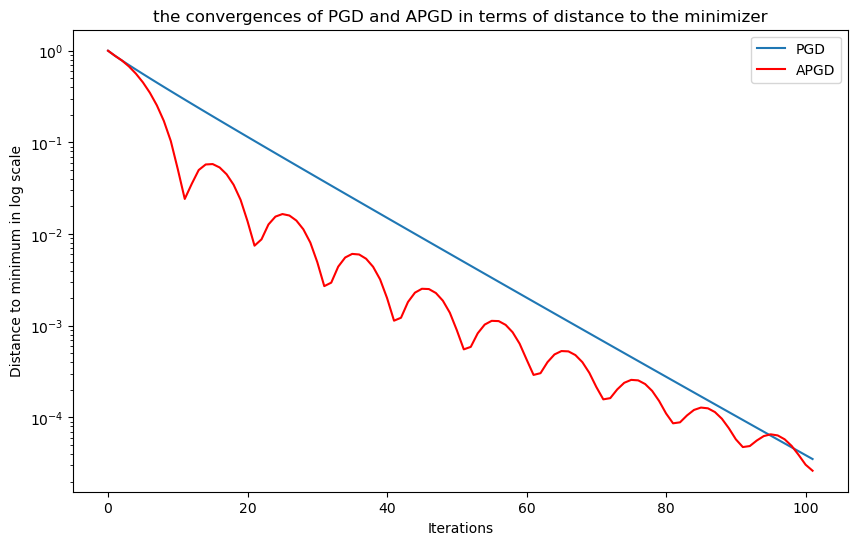

In [20]:
# Distance to the minimizer
plt.figure(figsize=(10, 6))
plt.plot(err_PGD, label="PGD")
plt.plot(err_APGD, "r", label="APGD")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Distance to minimum in log scale")
plt.title("the convergences of PGD and APGD in terms of distance to the minimizer")
plt.legend()
plt.show()

<div class="alert alert-warning">
    
In the first iterations, the error of PGD and APGD are the same. Starting from a certain iteration, the error of APGD decrease faster than the error of PGD. Alse we can notice that PGD error decrease lineary.
</div>

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

In [21]:
x_PGD, obj_PGD, err_PGD = PGD(
    x0,
    loss_linreg,
    grad_linreg,
    L2_norm,
    prox_L2,
    step=smoothness_const_linreg(A),
    lmbd=lmbd,
    verbose=False,
)

In [22]:
x_APGD, obj_APGD, err_APGD = APGD(
    x0,
    loss_linreg,
    grad_linreg,
    L2_norm,
    prox_L2,
    step=smoothness_const_linreg(A),
    lmbd=lmbd,
    verbose=False,
)

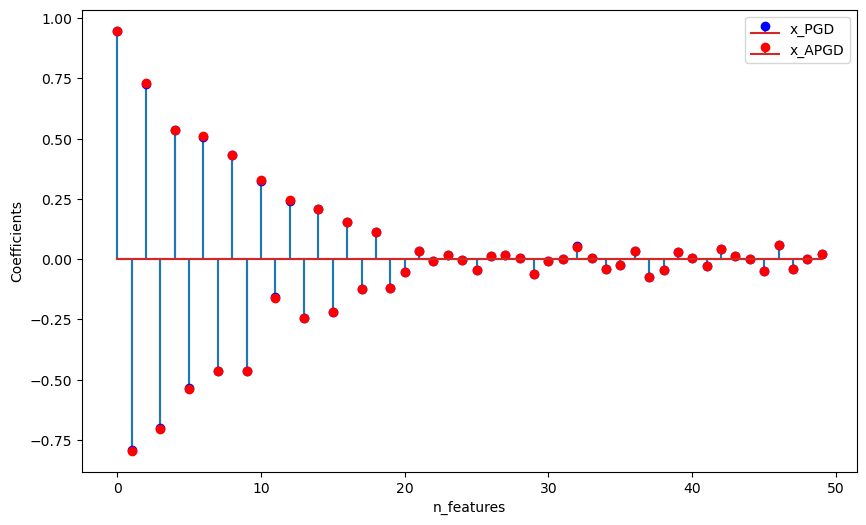

In [23]:
plt.figure(figsize=(10, 6))
plt.stem(x_PGD, markerfmt="bo", label="x_PGD")
plt.stem(x_APGD, markerfmt="ro", label="x_APGD")

plt.legend()
plt.xlabel("n_features")
plt.ylabel("Coefficients")
plt.show()

<div class="alert alert-warning">

the two methods give the same results.
</div>

### Correlation influence

We are going to see the impact of correlation on the two methods. We are going to simulate four datasets (for linear regression and logistic regression).

We noticed that the generation of datasets is based on the 'coefs' given as input in the simulation function. With this assumption, we can compare each solution (for a specific correlation coeffition) to the 'coefs' vector concidered as a solution.

#### PGD & APGD for linear regression

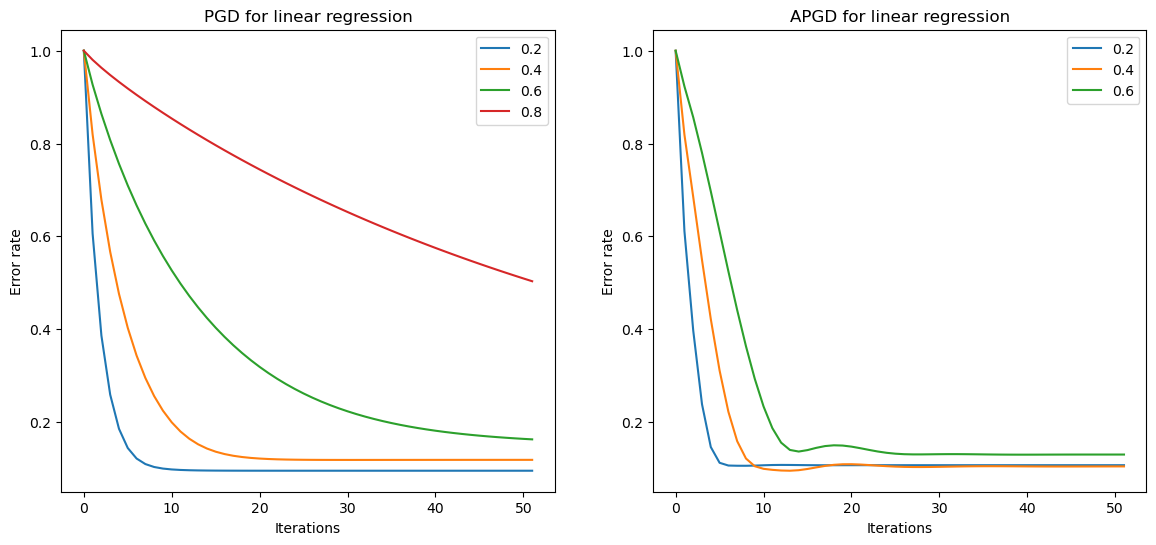

In [24]:
corr = [0.2, 0.4, 0.6, 0.8]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

for i in range(len(corr)):
    A, b = simu_linreg(coefs, corr=corr[i])

    x_PGD, obj_PGD, err_PGD = PGD(
        x0,
        loss_linreg,
        grad_linreg,
        L2_norm,
        prox_L2,
        step=smoothness_const_linreg(A),
        lmbd=lmbd,
        verbose=False,
    )

    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.plot(err_PGD, label=corr[i])
    plt.legend()
    plt.title("PGD for linear regression")


plt.subplot(1, 2, 2)

for i in range(3):
    A, b = simu_linreg(coefs, corr=corr[i])

    x_APGD, obj_APGD, err_APGD = APGD(
        x0,
        loss_linreg,
        grad_linreg,
        L2_norm,
        prox_L2,
        step=smoothness_const_linreg(A),
        lmbd=lmbd,
        verbose=False,
    )

    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.plot(err_APGD, label=corr[i])
    plt.legend()

    plt.title("APGD for linear regression")


plt.show()

#### PGD & APGD for logistic regression

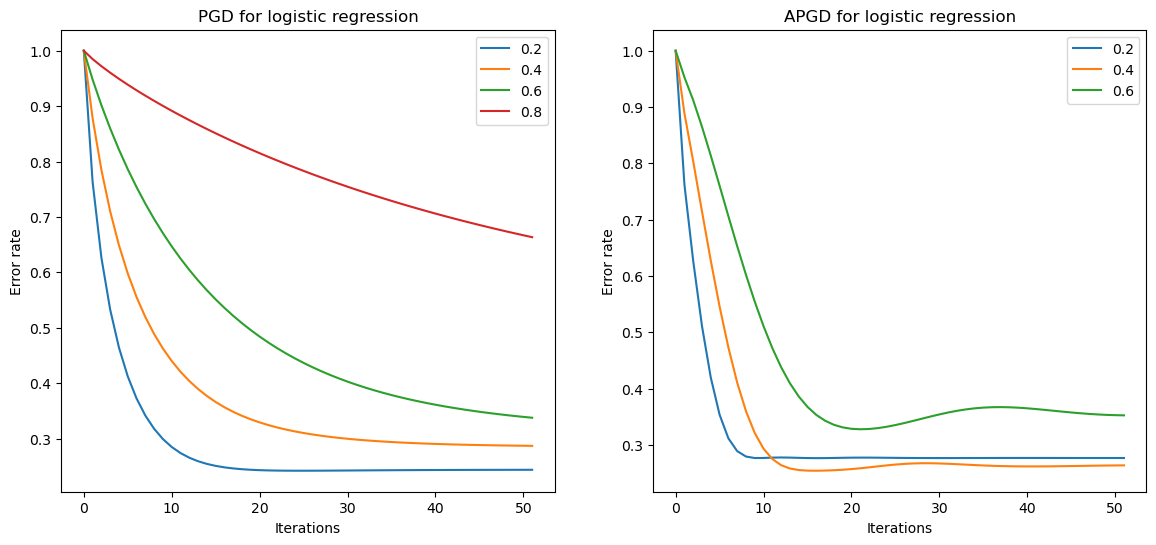

In [25]:
corr = [0.2, 0.4, 0.6, 0.8]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

for i in range(len(corr)):
    A, b = simu_logreg(coefs, corr=corr[i])

    x_PGD, obj_PGD, err_PGD = PGD(
        x0,
        loss_logreg,
        grad_logreg,
        L2_norm,
        prox_L2,
        step=smoothness_const_loreg(A),
        lmbd=lmbd,
        verbose=False,
    )

    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.plot(err_PGD, label=corr[i])
    plt.legend()
    plt.title("PGD for logistic regression")


plt.subplot(1, 2, 2)

for i in range(3):
    A, b = simu_logreg(coefs, corr=corr[i])

    x_APGD, obj_APGD, err_APGD = APGD(
        x0,
        loss_logreg,
        grad_logreg,
        L2_norm,
        prox_L2,
        step=smoothness_const_loreg(A),
        lmbd=lmbd,
        verbose=False,
    )

    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.plot(err_APGD, label=corr[i])
    plt.legend()

    plt.title("APGD for logistic regression")


plt.show()

<div class="alert alert-warning">

- the smaller the correlation, the better the perforamnce for all cases. we can conclude that if the correlation between features is small, the two methods perform better. This is due to the fact that the Lipschitz constant grows with the amount of correlation and the convergence rate is propotional to it


- Another observation is that both methods are close when the correlation value is low but the APGD method outperforms PGD when the correlation value gets higher.
</div>

### Ridge penalization (lambda)

We are going to see the impact of lamnda on the two methods and for linear and logistic regression

#### PGD & APGD for linear regression

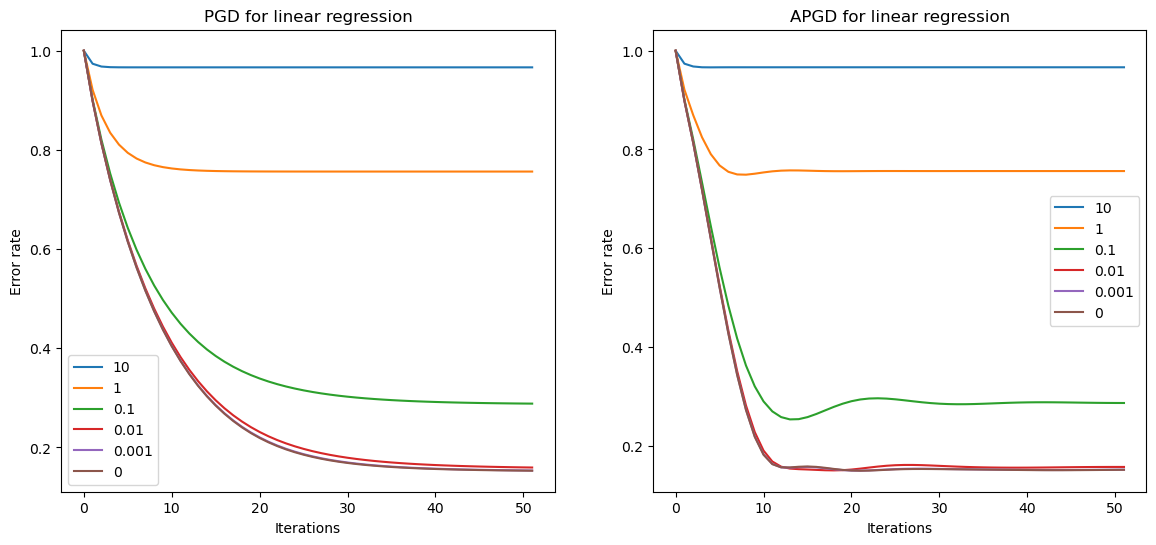

In [26]:
A, b = simu_linreg(coefs)
LAMBDA = [10, 1, 0.1, 0.01, 0.001, 0]
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

for i in range(len(LAMBDA)):
    x_PGD, obj_PGD, err_PGD = PGD(
        x0,
        loss_linreg,
        grad_linreg,
        L2_norm,
        prox_L2,
        step=smoothness_const_linreg(A),
        lmbd=LAMBDA[i],
        verbose=False,
    )
    plt.plot(err_PGD, label=LAMBDA[i])
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.title("PGD for linear regression")


plt.subplot(1, 2, 2)

for i in range(len(LAMBDA)):
    x_APGD, obj_APGD, err_APGD = APGD(
        x0,
        loss_linreg,
        grad_linreg,
        L2_norm,
        prox_L2,
        step=smoothness_const_linreg(A),
        lmbd=LAMBDA[i],
        verbose=False,
    )
    plt.plot(err_APGD, label=LAMBDA[i])
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.title("APGD for linear regression")


plt.show()

#### PGD & APGD for logistic regression

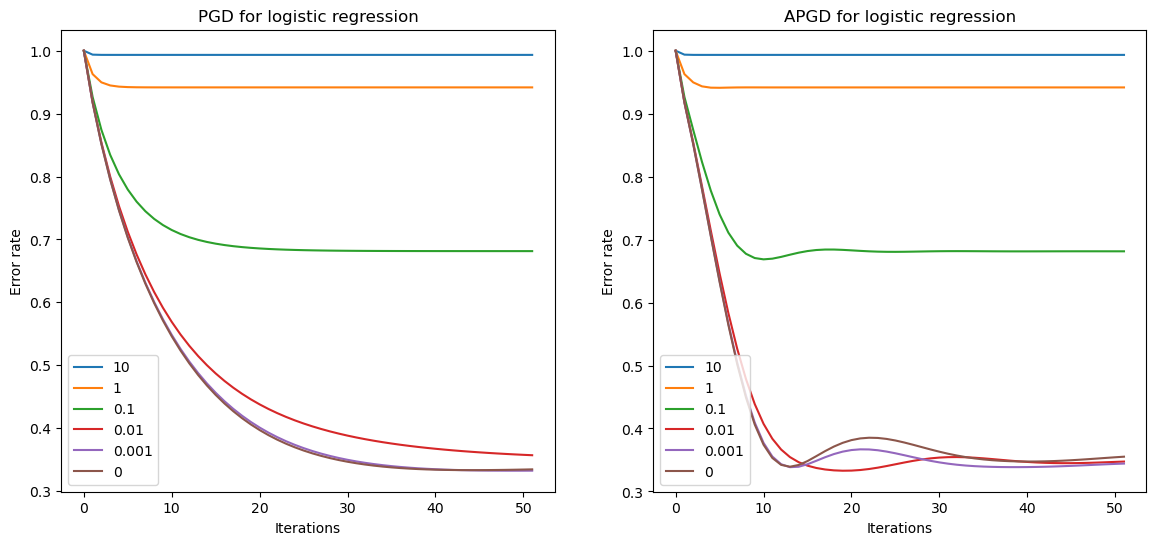

In [27]:
A, b = simu_logreg(coefs)
LAMBDA = [10, 1, 0.1, 0.01, 0.001, 0]
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

for i in range(len(LAMBDA)):
    x_PGD, obj_PGD, err_PGD = PGD(
        x0,
        loss_logreg,
        grad_logreg,
        L2_norm,
        prox_L2,
        step=smoothness_const_loreg(A),
        lmbd=LAMBDA[i],
        verbose=False,
    )
    plt.plot(err_PGD, label=LAMBDA[i])
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.title("PGD for logistic regression")


plt.subplot(1, 2, 2)

for i in range(len(LAMBDA)):
    x_APGD, obj_APGD, err_APGD = APGD(
        x0,
        loss_logreg,
        grad_logreg,
        L2_norm,
        prox_L2,
        step=smoothness_const_loreg(A),
        lmbd=LAMBDA[i],
        verbose=False,
    )
    plt.plot(err_APGD, label=LAMBDA[i])
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Error rate")
    plt.title("APGD for logistic regression")


plt.show()

<div class="alert alert-warning">

We notice that when the penalization is higher,the convergence is faster but the error rate converges to a higher value for both methods. This can be simply explained by the fact that the coefficients are divided by the penalization parameter, so the higher the penalization parameter, the lower the coefficients and the higher the error rate.
</div>

### L1 and L2 comparison

#### L1/L2 for linear regression with PGD (lmbda = 0.01)

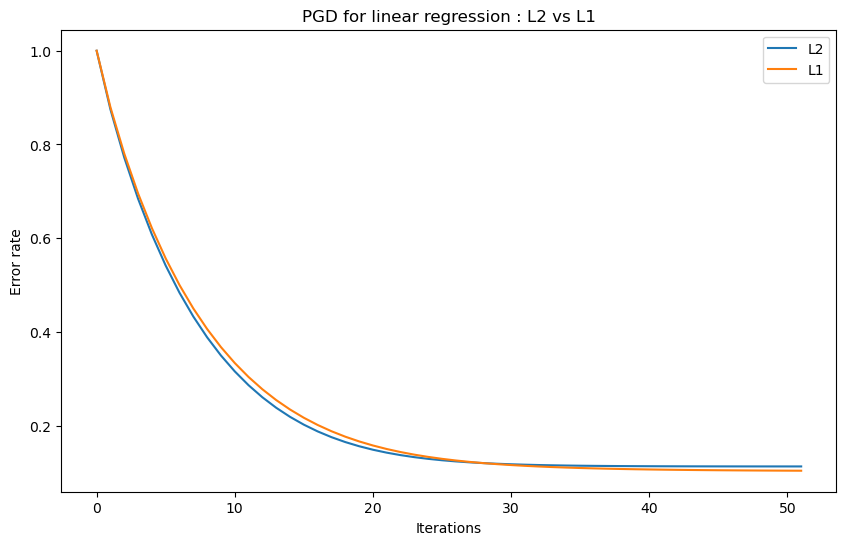

In [28]:
A, b = simu_linreg(coefs)
plt.figure(figsize=(10, 6))

_, _, err_L2 = PGD(
    x0,
    loss_linreg,
    grad_linreg,
    L2_norm,
    prox_L2,
    step=smoothness_const_linreg(A),
    lmbd=0.01,
    verbose=False,
)

_, _, err_L1 = PGD(
    x0,
    loss_linreg,
    grad_linreg,
    L1_norm,
    prox_L1,
    step=smoothness_const_linreg(A),
    lmbd=0.01,
    verbose=False,
)

plt.plot(err_L2, label="L2")
plt.plot(err_L1, label="L1")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error rate")
plt.title("PGD for linear regression : L2 vs L1")

plt.show()

#### Lasso/Ridge for linear regression with APGD (lmbda = 0.01)

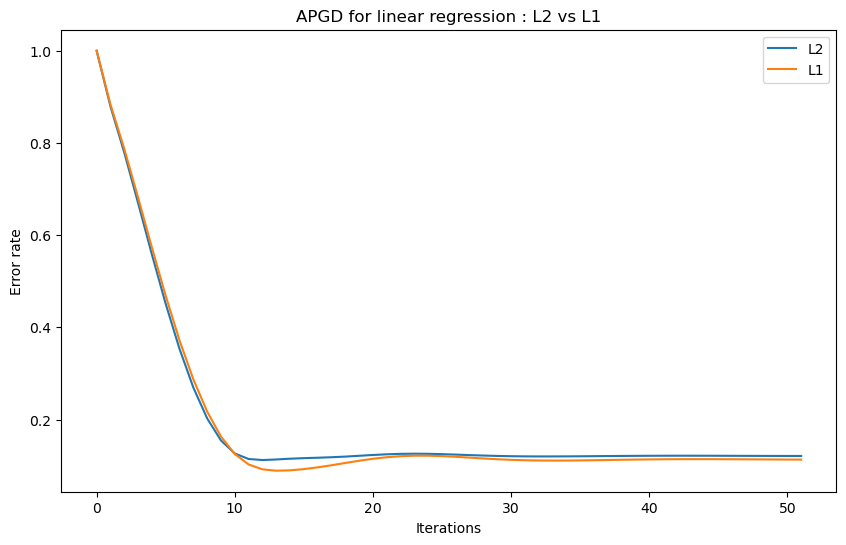

In [29]:
A, b = simu_linreg(coefs)
plt.figure(figsize=(10, 6))

_, _, err_L2 = APGD(
    x0,
    loss_linreg,
    grad_linreg,
    L2_norm,
    prox_L2,
    step=smoothness_const_linreg(A),
    lmbd=0.01,
    verbose=False,
)

_, _, err_L1 = APGD(
    x0,
    loss_linreg,
    grad_linreg,
    L1_norm,
    prox_L1,
    step=smoothness_const_linreg(A),
    lmbd=0.01,
    verbose=False,
)

plt.plot(err_L2, label="L2")
plt.plot(err_L1, label="L1")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error rate")
plt.title("APGD for linear regression : L2 vs L1")

plt.show()

<div class="alert alert-warning">

We have almost the same convergence speed for lasso and rigde , with the same algorithm and the same loss function.
</div>

#### L1/L2 for linear regression with PGD (lmbda = 0.1)

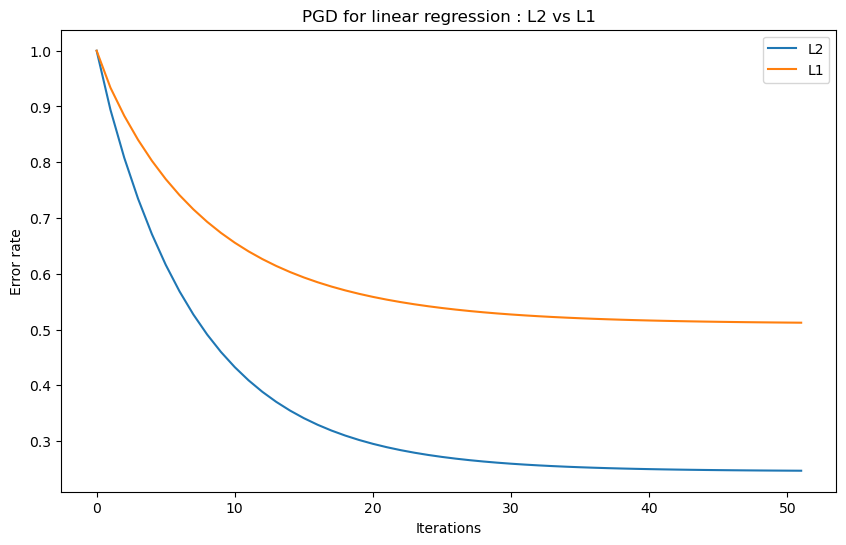

In [30]:
A, b = simu_linreg(coefs)
plt.figure(figsize=(10, 6))

_, _, err_L2 = PGD(
    x0,
    loss_linreg,
    grad_linreg,
    L2_norm,
    prox_L2,
    step=smoothness_const_linreg(A),
    lmbd=0.1,
    verbose=False,
)

_, _, err_L1 = PGD(
    x0,
    loss_linreg,
    grad_linreg,
    L1_norm,
    prox_L1,
    step=smoothness_const_linreg(A),
    lmbd=0.1,
    verbose=False,
)

plt.plot(err_L2, label="L2")
plt.plot(err_L1, label="L1")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error rate")
plt.title("PGD for linear regression : L2 vs L1")

plt.show()

#### Lasso/Ridge for linear regression with APGD (lmbda = 0.1)

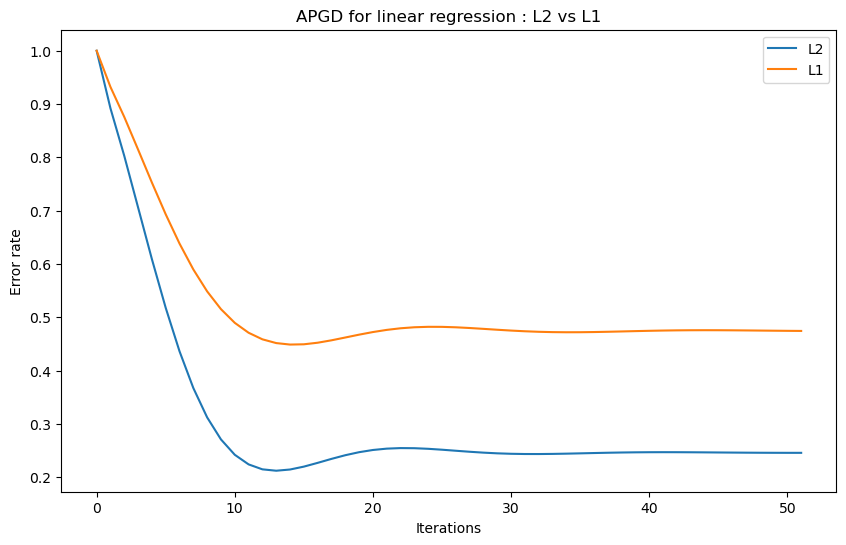

In [31]:
A, b = simu_linreg(coefs)
plt.figure(figsize=(10, 6))

_, _, err_L2 = APGD(
    x0,
    loss_linreg,
    grad_linreg,
    L2_norm,
    prox_L2,
    step=smoothness_const_linreg(A),
    lmbd=0.1,
    verbose=False,
)

_, _, err_L1 = APGD(
    x0,
    loss_linreg,
    grad_linreg,
    L1_norm,
    prox_L1,
    step=smoothness_const_linreg(A),
    lmbd=0.1,
    verbose=False,
)

plt.plot(err_L2, label="L2")
plt.plot(err_L1, label="L1")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error rate")
plt.title("APGD for linear regression : L2 vs L1")

plt.show()

<div class="alert alert-warning">

If we change the penalty parameter, we can notice that the convergence error rate of the L1 is always higher than the L2 error rate. This could be explained by the fact that a lot of coefficients are shrinked to zero when we used the Lasso proximal operator.
</div>